# Random Forest - náhodnost na dvou úrovních

## Cíl lekce

V této lekci pochopíme kompletní algoritmus Random Forest. Naučíme se, jak přidání náhodného výběru features snižuje korelaci mezi stromy a zlepšuje výkon ensemble.

## Motivace: Proč Bagging nestačí?

V předchozí lekci jsme viděli, že Bagging snižuje varianci:

$$\text{Var}(\hat{f}_{bag}) = \rho\sigma^2 + \frac{1-\rho}{B}\sigma^2$$

**Problém:** První člen (ρσ²) se nesnižuje s počtem stromů!

### Korelace stromů v Baggingu:

Když máme silný prediktor (feature), všechny stromy ho použijí jako první rozdělení:

| Bootstrap vzorek | První rozdělení | Podobnost |
|-----------------|-----------------|----------|
| Vzorek 1 | Feature X > 5.0 | ✓ |
| Vzorek 2 | Feature X > 5.2 | ✓ |
| Vzorek 3 | Feature X > 4.9 | ✓ |

**Všechny stromy jsou podobné!** → Vysoká korelace ρ → Menší zlepšení z ensemble

### Řešení: Random Forest

Přidáme **druhou úroveň náhodnosti** - náhodný výběr features!

## Dvě úrovně náhodnosti v Random Forest

### Úroveň 1: Bootstrap Sampling (řádky)

**Co děláme:** Vybereme náhodné řádky s vracením

**Příklad:**
| Původní data | Bootstrap 1 | Bootstrap 2 |
|--------------|-------------|-------------|
| Řádek 1 | Řádek 1 | Řádek 2 |
| Řádek 2 | Řádek 1 | Řádek 3 |
| Řádek 3 | Řádek 3 | Řádek 3 |
| Řádek 4 | Řádek 4 | Řádek 5 |
| Řádek 5 | Řádek 4 | Řádek 5 |

**Efekt:** Každý strom vidí jiná data

### Úroveň 2: Random Feature Selection (sloupce)

**Co děláme:** V každém uzlu vybereme náhodnou podmnožinu features

**Příklad (máme 4 features, vybíráme 2):**

| Uzel | Všechny features | Náhodně vybrané | Nejlepší z vybraných |
|------|------------------|-----------------|---------------------|
| Kořen stromu 1 | A, B, C, D | A, C | A > 5 |
| Kořen stromu 2 | A, B, C, D | B, D | D > 3 |
| Kořen stromu 3 | A, B, C, D | A, B | B > 7 |

**Efekt:** Stromy používají různé features → nižší korelace!

### Proč potřebujeme obě úrovně?

| Technika | Bootstrap | Random Features | Korelace stromů | Diverzita |
|----------|-----------|-----------------|-----------------|----------|
| Bagging | ✓ | ✗ | Vysoká | Nízká |
| Random Forest | ✓ | ✓ | Nízká | Vysoká |

## Algoritmus Random Forest - krok po kroku

### Pseudokód:

```
VSTUP: 
  - Trénovací data: (X, y) s n vzorky a p features
  - Počet stromů: B
  - Počet features pro výběr: m

ALGORITMUS:
Pro b = 1 až B:
    1. Vytvoř bootstrap vzorek (Xb, yb) velikosti n
    2. Trénuj rozhodovací strom Tb:
       Pro každý uzel:
         a) Náhodně vyber m features z p možných
         b) Najdi nejlepší rozdělení pouze z těchto m features
         c) Rozděl uzel podle nejlepšího rozdělení
    3. Nech strom růst do maximální hloubky (bez prořezávání)
    4. Ulož strom Tb

PREDIKCE pro nový vstup x:
  - Klasifikace: Majoritní hlasování všech B stromů
  - Regrese: Průměr predikcí všech B stromů
```

### Klíčové rozdíly oproti běžnému stromu:

| Aspekt | Běžný strom | Random Forest strom |
|--------|-------------|--------------------|
| Data | Všechna původní | Bootstrap vzorek |
| Features v uzlu | Všech p | Náhodných m z p |
| Prořezávání | Ano (prevence overfitting) | Ne (chceme hluboké stromy) |
| Počet stromů | 1 | B (typicky 100-1000) |

## Parametr m (max_features) - klíč k úspěchu

### Co je m?

**m** = počet náhodně vybraných features v každém uzlu

### Doporučené hodnoty:

| Úloha | Doporučené m | Vzorec | Příklad (p=100) |
|-------|--------------|--------|------------------|
| **Klasifikace** | $m = \sqrt{p}$ | odmocnina z počtu features | m = 10 |
| **Regrese** | $m = \frac{p}{3}$ | třetina features | m = 33 |

**Symboly:**
- **p** = celkový počet features v datasetu
- **m** = počet náhodně vybraných features
- **√** = odmocnina

### Trade-off při volbě m:

| m | Síla stromů | Korelace stromů | Výsledek |
|---|-------------|-----------------|----------|
| **Malé m** (např. 1) | Slabé | Velmi nízká | Může být nepřesné |
| **Střední m** (√p) | Střední | Nízká | Optimální ✅ |
| **Velké m** (p) | Silné | Vysoká | Jako Bagging |

### Příklad vlivu m:

**Dataset:** 12 features (A-L), 100 vzorků

**Scenario 1: m = 2** (malé)
- Uzel 1 vybírá z: [B, F] → použije B
- Uzel 2 vybírá z: [C, K] → použije K
- Stromy jsou velmi různé, ale každý je slabý

**Scenario 2: m = 4** (√12 ≈ 3.5)
- Uzel 1 vybírá z: [A, D, F, H] → použije A
- Uzel 2 vybírá z: [B, E, G, L] → použije E
- Dobrá rovnováha síly a diverzity

**Scenario 3: m = 12** (všechny)
- Všechny uzly vybírají ze všech features
- Silné stromy, ale všechny podobné (vysoká korelace)

## Feature Importance v Random Forest

Random Forest poskytuje dva způsoby měření důležitosti features:

### 1. Mean Decrease in Impurity (MDI)

**Vzorec:**

$$FI_j^{MDI} = \frac{1}{B} \sum_{b=1}^{B} \sum_{t \in T_b} \mathbb{I}(j_t = j) \cdot p_t \cdot \Delta_t$$

**Vysvětlení VŠECH symbolů:**
- **$FI_j^{MDI}$** = Feature Importance pro j-tý feature metodou MDI
- **$\frac{1}{B}$** = průměrování přes všechny stromy
- **B** = počet stromů v Random Forest
- **$\sum_{b=1}^{B}$** = součet přes všechny stromy
- **b** = index stromu (1 až B)
- **$\sum_{t \in T_b}$** = součet přes všechny uzly t ve stromu $T_b$
- **$T_b$** = b-tý strom
- **t** = uzel ve stromu
- **$\mathbb{I}(j_t = j)$** = indikátor: 1 pokud uzel t používá feature j, jinak 0
- **$j_t$** = feature použitý v uzlu t
- **j** = index feature, jehož importance počítáme
- **$p_t$** = podíl vzorků v uzlu t (váha uzlu)
- **$\Delta_t$** = pokles nečistoty v uzlu t (např. pokles Gini)

### 2. Permutation Importance

**Postup:**
1. Vypočítej baseline přesnost na OOB datech
2. Náhodně zamíchej hodnoty j-tého feature
3. Vypočítej novou přesnost
4. Importance = pokles přesnosti

**Vzorec:**

$$FI_j^{Perm} = \frac{1}{B} \sum_{b=1}^{B} (Acc_b^{OOB} - Acc_b^{OOB,\pi_j})$$

**Vysvětlení symbolů:**
- **$FI_j^{Perm}$** = Permutation importance j-tého feature
- **$Acc_b^{OOB}$** = přesnost b-tého stromu na jeho OOB datech
- **$Acc_b^{OOB,\pi_j}$** = přesnost po zamíchání j-tého feature
- **$\pi_j$** = náhodná permutace j-tého feature

### Porovnání metod:

| Metoda | Výhody | Nevýhody |
|--------|--------|----------|
| **MDI** | Rychlé, součást trénování | Může být zkreslené pro kategorické features |
| **Permutation** | Přímá interpretace, robustní | Pomalejší, vyžaduje OOB data |

## Out-of-Bag (OOB) Error

### Jak funguje OOB validace?

Každý strom má svoje OOB vzorky (které neviděl při trénování):

| Vzorek | Strom 1 | Strom 2 | Strom 3 | OOB predikce |
|--------|---------|---------|---------|---------------|
| 1 | Trénoval | OOB | Trénoval | Ze stromu 2 |
| 2 | OOB | OOB | Trénoval | Ze stromů 1,2 |
| 3 | Trénoval | Trénoval | OOB | Ze stromu 3 |
| 4 | OOB | Trénoval | OOB | Ze stromů 1,3 |

### Výpočet OOB Error:

Pro každý vzorek i:
1. Najdi všechny stromy, kde i byl OOB
2. Získej predikce pouze z těchto stromů
3. Agreguj predikce (hlasování/průměr)
4. Porovnej s pravou hodnotou

**Vzorec pro OOB Error (klasifikace):**

$$OOB_{error} = \frac{1}{n} \sum_{i=1}^{n} \mathbb{I}(y_i \neq \hat{y}_i^{OOB})$$

**Vysvětlení symbolů:**
- **$OOB_{error}$** = Out-of-bag chyba
- **n** = počet vzorků
- **$\sum_{i=1}^{n}$** = součet přes všechny vzorky
- **$\mathbb{I}(\text{podmínka})$** = 1 když podmínka platí, 0 jinak
- **$y_i$** = skutečná třída i-tého vzorku
- **$\hat{y}_i^{OOB}$** = OOB predikce pro i-tý vzorek

### Výhody OOB validace:

1. **"Zdarma"** - nepotřebujeme separátní validační set
2. **Efektivní** - využívá všechna data
3. **Nezkreslené** - každý vzorek je testován na stromech, které ho neviděly
4. **Podobné CV** - OOB error ≈ leave-one-out cross-validation

## Příklad: Random Forest na malém datasetu

### Dataset: 6 studentů, 3 features

| Student | Hodiny (A) | Účast % (B) | IQ (C) | Prošel |
|---------|------------|-------------|--------|--------|
| 1 | 2 | 40 | 95 | Ne |
| 2 | 3 | 60 | 105 | Ne |
| 3 | 5 | 70 | 100 | Ano |
| 4 | 6 | 80 | 110 | Ano |
| 5 | 7 | 85 | 102 | Ano |
| 6 | 8 | 90 | 108 | Ano |

### Parametry Random Forest:
- B = 3 stromy
- m = 2 (vybereme 2 features z 3)

### Strom 1:
**Bootstrap:** [1, 2, 2, 4, 5, 6] → OOB: [3]

**Kořen:** Vybírá z features [A, B]
- Nejlepší: A > 4 (rozdělí Ne|Ne|Ne vs. Ano|Ano|Ano)

### Strom 2:
**Bootstrap:** [1, 3, 3, 4, 5, 6] → OOB: [2]

**Kořen:** Vybírá z features [B, C]
- Nejlepší: B > 65 (rozdělí Ne vs. Ano|Ano|Ano|Ano|Ano)

### Strom 3:
**Bootstrap:** [2, 3, 4, 5, 5, 6] → OOB: [1]

**Kořen:** Vybírá z features [A, C]
- Nejlepší: C > 103 (rozdělí Ne|Ano|Ne vs. Ano|Ano|Ano)

### Predikce pro nového studenta:
**Nový:** Hodiny=4, Účast=65, IQ=104

| Strom | Pravidlo | Predikce |
|-------|----------|----------|
| 1 | A=4 > 4? Ne | Ne |
| 2 | B=65 > 65? Ne | Ne |
| 3 | C=104 > 103? Ano | Ano |

**Hlasování:** 2×Ne, 1×Ano → **Finální: Ne**

## Import knihoven

Nyní, když rozumíme kompletnímu algoritmu Random Forest, můžeme importovat knihovny pro praktické ukázky.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
import matplotlib.patches as mpatches

## Vizualizace dvou úrovní náhodnosti

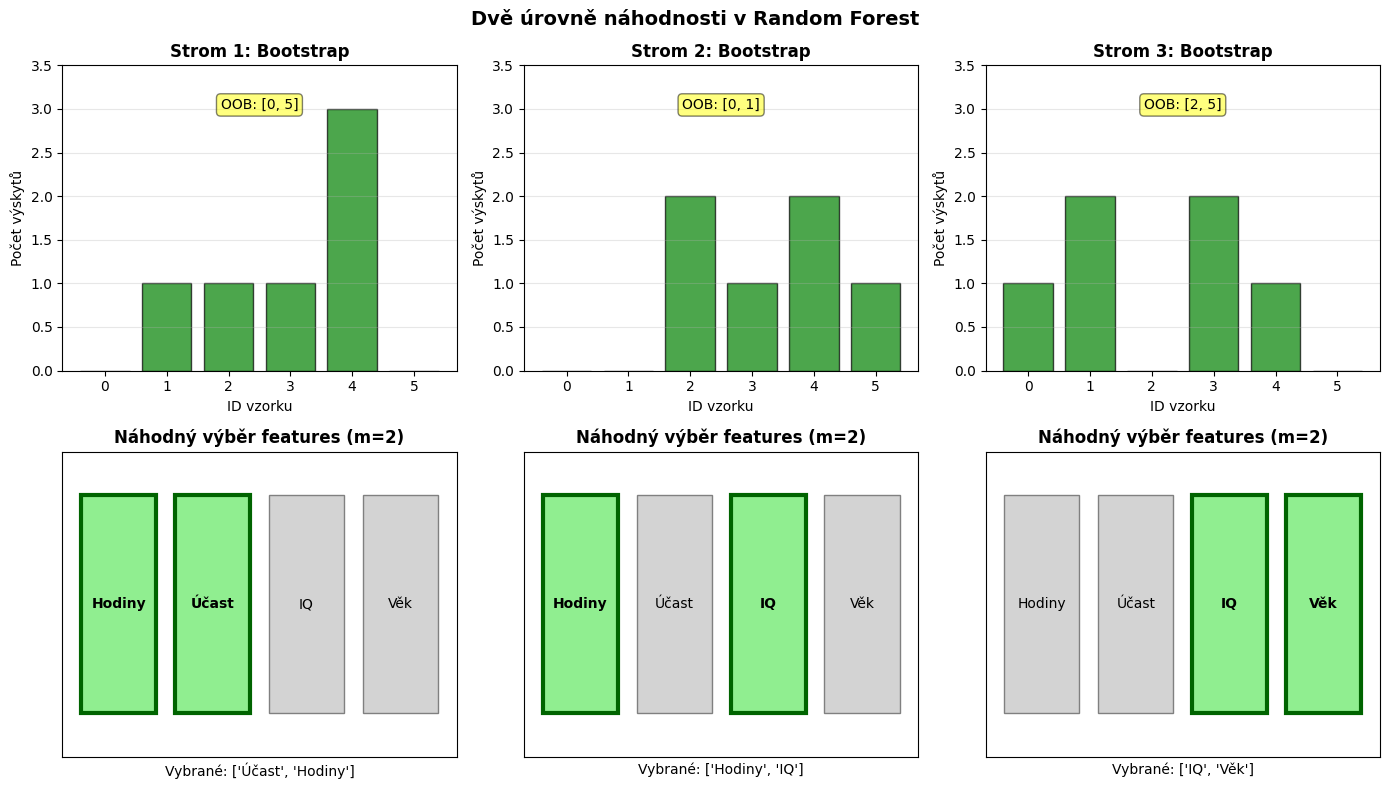

In [2]:
# Vizualizace náhodného výběru features
np.random.seed(42)

fig, axes = plt.subplots(2, 3, figsize=(14, 8))

# Původní data
features = ['Hodiny', 'Účast', 'IQ', 'Věk']
n_features = len(features)
m = 2  # počet vybraných features

# Pro každý strom
for tree_idx in range(3):
    # Bootstrap sampling (horní řádek)
    ax_top = axes[0, tree_idx]
    n_samples = 6
    bootstrap_indices = np.random.choice(n_samples, n_samples, replace=True)
    unique, counts = np.unique(bootstrap_indices, return_counts=True)
    
    all_counts = np.zeros(n_samples)
    for u, c in zip(unique, counts):
        all_counts[u] = c
    
    colors = ['red' if c == 0 else 'green' for c in all_counts]
    bars = ax_top.bar(range(n_samples), all_counts, color=colors, alpha=0.7, edgecolor='black')
    ax_top.set_xlabel('ID vzorku')
    ax_top.set_ylabel('Počet výskytů')
    ax_top.set_title(f'Strom {tree_idx+1}: Bootstrap', fontweight='bold')
    ax_top.set_ylim(0, 3.5)
    ax_top.grid(True, alpha=0.3, axis='y')
    
    # OOB vzorky
    oob = [i for i in range(n_samples) if all_counts[i] == 0]
    if oob:
        ax_top.text(2.5, 3, f'OOB: {oob}', fontsize=10, ha='center',
                   bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))
    
    # Random feature selection (dolní řádek)
    ax_bottom = axes[1, tree_idx]
    
    # Vyber náhodné features
    selected_features = np.random.choice(n_features, m, replace=False)
    
    # Vizualizace features
    for i, feature in enumerate(features):
        if i in selected_features:
            color = 'lightgreen'
            edgecolor = 'darkgreen'
            linewidth = 3
        else:
            color = 'lightgray'
            edgecolor = 'gray'
            linewidth = 1
        
        rect = Rectangle((i, 0), 0.8, 1, facecolor=color, 
                        edgecolor=edgecolor, linewidth=linewidth)
        ax_bottom.add_patch(rect)
        ax_bottom.text(i+0.4, 0.5, feature, ha='center', va='center', 
                      fontsize=10, fontweight='bold' if i in selected_features else 'normal')
    
    ax_bottom.set_xlim(-0.2, n_features)
    ax_bottom.set_ylim(-0.2, 1.2)
    ax_bottom.set_xticks([])
    ax_bottom.set_yticks([])
    ax_bottom.set_title(f'Náhodný výběr features (m={m})', fontweight='bold')
    ax_bottom.set_xlabel(f'Vybrané: {[features[i] for i in selected_features]}')

plt.suptitle('Dvě úrovně náhodnosti v Random Forest', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Vliv parametru m na korelaci stromů

In [3]:
# Simulace vlivu m na diverzitu stromů
np.random.seed(42)

p = 20  # celkový počet features
n_trees = 100

# Různé hodnoty m
m_values = [1, 2, 5, 10, 15, 20]
correlations = []

# Simulujeme pro každé m
for m in m_values:
    # Simulace výběru features pro každý strom
    feature_selections = []
    for _ in range(n_trees):
        selected = np.zeros(p)
        selected_indices = np.random.choice(p, m, replace=False)
        selected[selected_indices] = 1
        feature_selections.append(selected)
    
    # Výpočet průměrné korelace mezi stromy
    feature_selections = np.array(feature_selections)
    correlation_matrix = np.corrcoef(feature_selections)
    
    # Průměrná korelace (mimo diagonálu)
    mask = ~np.eye(n_trees, dtype=bool)
    avg_correlation = correlation_matrix[mask].mean()
    correlations.append(avg_correlation)

# Vizualizace
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Graf 1: Korelace vs. m
ax1.plot(m_values, correlations, 'bo-', linewidth=2, markersize=8)
ax1.axvline(x=np.sqrt(p), color='red', linestyle='--', label=f'm=√p={np.sqrt(p):.1f}')
ax1.axvline(x=p/3, color='green', linestyle='--', label=f'm=p/3={p/3:.1f}')
ax1.set_xlabel('m (počet vybraných features)', fontsize=12)
ax1.set_ylabel('Průměrná korelace mezi stromy', fontsize=12)
ax1.set_title('Vliv m na korelaci stromů', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Graf 2: Trade-off diagram
m_range = np.linspace(1, p, 50)
tree_strength = m_range / p  # síla roste s m
tree_correlation = m_range / p  # korelace také roste s m
forest_error = tree_correlation * 0.3 + (1 - tree_strength) * 0.7  # simulovaná chyba

ax2.plot(m_range, tree_strength, 'g-', linewidth=2, label='Síla stromů')
ax2.plot(m_range, tree_correlation, 'r-', linewidth=2, label='Korelace stromů')
ax2.plot(m_range, forest_error, 'b-', linewidth=3, label='Chyba lesa')

# Optimum
optimal_m = m_range[np.argmin(forest_error)]
ax2.axvline(x=optimal_m, color='black', linestyle=':', alpha=0.5)
ax2.plot(optimal_m, min(forest_error), 'ko', markersize=10)
ax2.annotate('Optimum', xy=(optimal_m, min(forest_error)), 
            xytext=(optimal_m+2, min(forest_error)+0.05),
            arrowprops=dict(arrowstyle='->'))

ax2.set_xlabel('m (počet vybraných features)', fontsize=12)
ax2.set_ylabel('Relativní hodnota', fontsize=12)
ax2.set_title('Trade-off: Síla vs. Korelace', fontsize=13, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

C:\Users\petrrozkosny\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


## Simulace Feature Importance

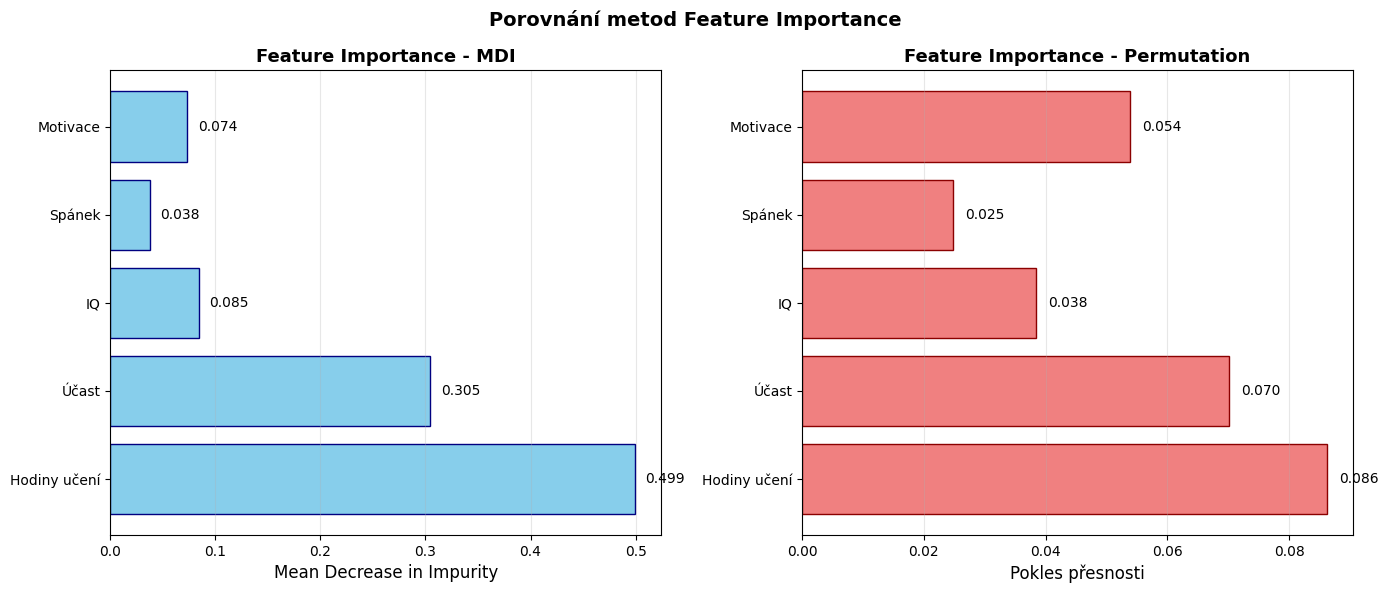

In [4]:
# Simulace výpočtu feature importance
np.random.seed(42)

features = ['Hodiny učení', 'Účast', 'IQ', 'Spánek', 'Motivace']
n_features = len(features)
n_trees = 100

# Simulace: které features jsou skutečně důležité
true_importance = [0.35, 0.25, 0.15, 0.10, 0.15]  # Hodiny a Účast nejdůležitější

# MDI simulace
mdi_scores = np.zeros(n_features)

for tree in range(n_trees):
    # Každý strom přispívá k importance
    for feat_idx in range(n_features):
        # Pravděpodobnost použití závisí na skutečné důležitosti
        if np.random.random() < true_importance[feat_idx] * 2:
            # Přidej příspěvek (simulace poklesu Gini)
            contribution = np.random.exponential(true_importance[feat_idx])
            mdi_scores[feat_idx] += contribution

# Normalizace
mdi_scores = mdi_scores / mdi_scores.sum()

# Permutation importance simulace
perm_scores = []
for feat_idx in range(n_features):
    # Simulace poklesu přesnosti po permutaci
    baseline_accuracy = 0.85
    accuracy_drop = true_importance[feat_idx] * 0.3 * np.random.uniform(0.8, 1.2)
    perm_scores.append(accuracy_drop)

perm_scores = np.array(perm_scores)

# Vizualizace
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Graf 1: MDI
y_pos = np.arange(n_features)
axes[0].barh(y_pos, mdi_scores, color='skyblue', edgecolor='navy')
axes[0].set_yticks(y_pos)
axes[0].set_yticklabels(features)
axes[0].set_xlabel('Mean Decrease in Impurity', fontsize=12)
axes[0].set_title('Feature Importance - MDI', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')

# Přidání hodnot
for i, v in enumerate(mdi_scores):
    axes[0].text(v + 0.01, i, f'{v:.3f}', va='center')

# Graf 2: Permutation
axes[1].barh(y_pos, perm_scores, color='lightcoral', edgecolor='darkred')
axes[1].set_yticks(y_pos)
axes[1].set_yticklabels(features)
axes[1].set_xlabel('Pokles přesnosti', fontsize=12)
axes[1].set_title('Feature Importance - Permutation', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

# Přidání hodnot
for i, v in enumerate(perm_scores):
    axes[1].text(v + 0.002, i, f'{v:.3f}', va='center')

plt.suptitle('Porovnání metod Feature Importance', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## OOB Error vs. počet stromů

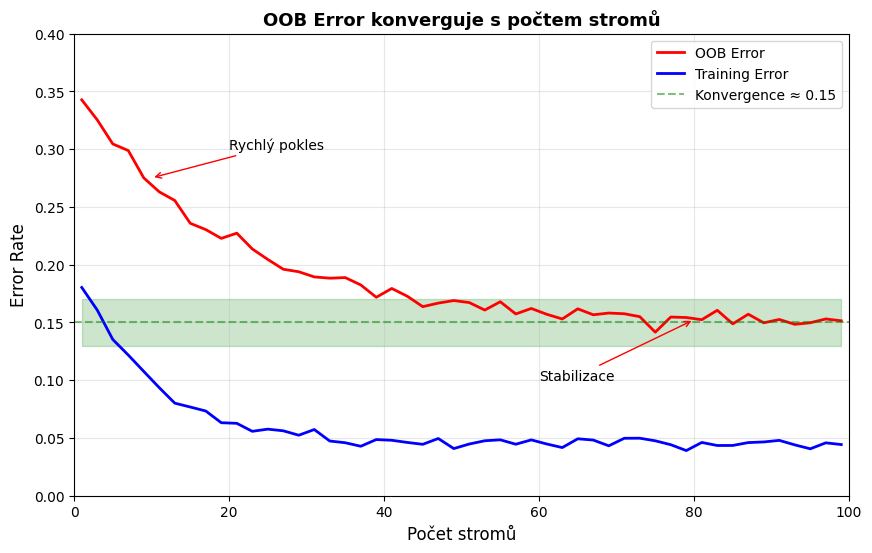

In [5]:
# Simulace OOB error s rostoucím počtem stromů
np.random.seed(42)

n_trees_range = range(1, 101, 2)
oob_errors = []
train_errors = []

# Simulace chyb
base_error = 0.15
for n_trees in n_trees_range:
    # OOB error klesá s počtem stromů a konverguje
    oob_error = base_error + 0.20 * np.exp(-n_trees/20) + np.random.normal(0, 0.005)
    oob_errors.append(max(0, oob_error))
    
    # Training error klesá rychleji
    train_error = base_error * 0.3 + 0.15 * np.exp(-n_trees/10) + np.random.normal(0, 0.003)
    train_errors.append(max(0, train_error))

plt.figure(figsize=(10, 6))
plt.plot(n_trees_range, oob_errors, 'r-', linewidth=2, label='OOB Error')
plt.plot(n_trees_range, train_errors, 'b-', linewidth=2, label='Training Error')

# Zvýraznění konvergence
plt.axhline(y=base_error, color='green', linestyle='--', alpha=0.5, label=f'Konvergence ≈ {base_error:.2f}')
plt.fill_between(n_trees_range, base_error-0.02, base_error+0.02, alpha=0.2, color='green')

plt.xlabel('Počet stromů', fontsize=12)
plt.ylabel('Error Rate', fontsize=12)
plt.title('OOB Error konverguje s počtem stromů', fontsize=13, fontweight='bold')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

# Anotace
plt.annotate('Rychlý pokles', xy=(10, oob_errors[4]), xytext=(20, 0.30),
            arrowprops=dict(arrowstyle='->', color='red'))
plt.annotate('Stabilizace', xy=(80, oob_errors[-10]), xytext=(60, 0.10),
            arrowprops=dict(arrowstyle='->', color='red'))

plt.xlim(0, 100)
plt.ylim(0, 0.40)
plt.show()

## Shrnutí

### Co jsme se naučili:

1. **Random Forest = Bagging + Random Feature Selection**
   - Dvě úrovně náhodnosti snižují korelaci mezi stromy

2. **Parametr m je klíčový:**
   - Klasifikace: m = √p
   - Regrese: m = p/3
   - Trade-off mezi silou a korelací stromů

3. **Feature Importance:**
   - MDI: rychlé, součást trénování
   - Permutation: robustnější, přímá interpretace

4. **OOB validace:**
   - "Zdarma" validace bez potřeby test setu
   - Každý vzorek testován na ~37% stromů

### Klíčové vzorce:

- **Random Forest predikce:** $\hat{f}_{RF}(x) = \frac{1}{B} \sum_{b=1}^{B} T_b(x)$
- **Doporučené m:** Klasifikace $m = \sqrt{p}$, Regrese $m = \frac{p}{3}$
- **OOB Error:** Využívá ~37% stromů pro každý vzorek

### Výhody Random Forest:

1. **Nízká korelace stromů** díky random feature selection
2. **Robustnost** vůči overfittingu
3. **Feature importance** jako bonus
4. **OOB validace** bez potřeby separátních dat

### Příští krok:
Implementace v sklearn a optimalizace hyperparametrů!